# The Inverse DFT

In [3]:
%run ../setup.ipynb

When we defined the Discrete Fourier Transform (DFT) ({numref}`dft`), we saw that it exactly encodes the amplitude ($A$) and phase ($\phi$) of a sinusoidal input, at least when the frequency matches one of the analysis frequencies.
Specifically, we saw that (for $m \notin \{0, N/2\}$),

```{math}
x[n] = A\cdot \cos\left(2\pi \cdot \frac{m}{N}\cdot n + \phi \right) \quad \Rightarrow \quad
X[m] = A \cdot \frac{N}{2} \cdot e^{\mathrm{j}\cdot \phi}.
```

Of course, this doesn't tell us much if $x[n]$ is *not* of that particular given form.
The DFT is still well defined, even if $x[n]$ is a completely arbitrary set of sample values:

```{math}
X[m] = \sum_{n=0}^{N-1} x[n] \cdot e^{-2\pi\cdot\mathrm{j}\cdot m\cdot n / N}
```

This raises the question: how do we interpret the coefficients $X[m]$ for arbitrary signals?
We'll answer this by showing that there exists an *inverse* DFT, which can reconstruct the input signal $x[n]$ exactly from only its DFT coefficients $X[m]$.

## Warm-up: single sinusoid

Before defining the full inverse DFT, let's first try to recover a single sinusoid from its DFT spectrum.

Recall from {numref}`example-sinusoids` that a sinusoid at an analysis frequency index $m$ will have two non-zero DFT coefficients: $X[m]$ and $X[N-m]$, which are complex conjugates of each other: their real parts are the same, and their imaginary parts are opposite:

```{math}
\begin{align*}
X[m] &= A \cdot \frac{N}{2} \cdot e^{\mathrm{j}\cdot \phi}\\
X[N-m] &= A \cdot \frac{N}{2} \cdot e^{-\mathrm{j}\cdot \phi}
\end{align*}
```

Each of these components can be used to produce a complex sinusoid $z_m[n]$ as follows:

```{math}
\begin{align*}
z_m[n] &= X[m] \cdot e^{-2\pi \cdot \mathrm{j} \cdot \frac{m}{N} \cdot n}\\
&= A \cdot \frac{N}{2} \cdot e^{\mathrm{j}\cdot \phi} \cdot e^{-2\pi \cdot \mathrm{j} \cdot \frac{m}{N} \cdot n}\\
&= A \cdot \frac{N}{2} \cdot e^{-\mathrm{j}\cdot \left(2\pi \cdot \frac{m}{N} \cdot n - \phi\right)}
\end{align*}
```

This is demonstrated visually in {numref}`recons`.

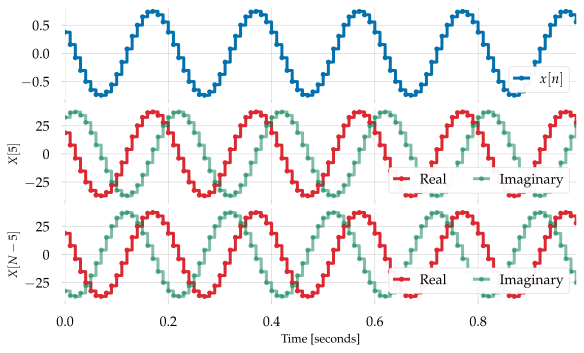

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=figaspect(0.6))

fs = 100
N = fs
f0 = 5 * fs / N
phi = np.pi / 3
t = np.arange(N) / fs
A = 0.75
x = A * np.cos(2 * np.pi * f0 * t + phi)

X = np.fft.fft(x)

X1 = np.zeros_like(X)
X1[5] = X[5]
x1 = np.fft.ifft(X1) * N

X2 = np.zeros_like(X)
X2[-5] = X[-5]
x2 = np.fft.ifft(X2) * N

freqs = np.fft.fftfreq(N, d=1/fs)

ax0.step(t, x, marker='.', where='post', label='$x[n]$')
ax0.legend(loc='lower right')
ax1.step(t, x1.real, marker='.', where='post', color=colors[1], label='Real')
ax1.step(t, x1.imag, marker='.', where='post', alpha=0.5, color=colors[5], label='Imaginary')
ax1.legend(loc='lower right', ncol=2)
ax1.set_ylabel('$X[5]$')
ax2.step(t, x2.real, marker='.', where='post', color=colors[1], label='Real')
ax2.step(t, x2.imag, marker='.', where='post', alpha=0.5, color=colors[5], label='Imaginary')
ax2.set_ylabel('$X[N-5]$')
ax2.set_xlabel('Time [seconds]')
ax2.legend(loc='lower right', ncol=2)

glue('recons', fig, display=False)

```{glue:figure} recons
---
name: recons
---

*Top*: a sinusoid $x[n] = 0.75 \cdot \cos(2\pi \cdot 5 \cdot \frac{n}{N} + \frac{\pi}{3})$ with $N = f_s = 100$.
*Middle*: the complex sinusoid corresponding to $X[5]$.
*Bottom*: the complex sinusoid corresponding to $X[N-5]$.  For complex sinusoids, the real and imaginary parts are plotted separately.
```

Because the imaginary parts of $X[m]$ and $X[N-m]$ are opposite ($X[m] = \overline{X[N-m]}$), summing the two doubles the real part and cancels the imaginary part, and we'll be left with a cosine wave at the appropriate phase:

```{math}
\begin{align*}
z_m[n] + z_{N-m}[n] &= A \cdot N \cdot \cos\left(-2\pi \cdot \frac{m}{N} \cdot n - \phi \right)\\
&= A \cdot N \cdot \cos\left(2\pi \cdot \frac{m}{N} \cdot n + \phi \right)\\
\end{align*}
```

This is exactly what we started with ($x[n]$), except there's an additional scaling of $N$ in front.
So, for at least this simple case of a single sinusoid, we can recover the input signal by generating the corresponding sinusoids with the parameters encoded by the magnitude and phase in the DFT, and dividing out the length of the signal $N$.

As it turns out, this strategy works in general: we don't need to assume that $x[n]$ is a single sinusoid!

## The inverse transform

````{admonition} The Inverse DFT

Let $x[n]$ be an arbitrary signal of $N$ samples, and let $X[m]$ be its DFT.
The **inverse DFT** is defined as

```{math}
x[n] = \frac{1}{N} \sum_{m=0}^{N-1} X[m] \cdot e^{+2\pi\cdot\mathrm{j} \cdot \frac{m}{N}\cdot n}
```

````

Intuitively, this says that the $n$th sample of the signal $x[n]$ can be recovered by averaging the $n$th samples of all DFT sinusoids.

Before proving the correctness of this definition, we should highlight the three key ways that it differs from the {numref}`forward DFT <dft>`:

1. There is a global scaling of $1/N$;
2. The sign of the complex exponent is flipped: positive for inverse transform, negative for the forward transform;
3. The summation ranges over $m$ (frequencies), rather than $n$ (samples).

### Proof

We'll make no assumptions about $x[n]$, apart from its duration ($N$).
Plugging in the definition of $X[m]$ (but using sample index $n'$ to avoid confusion with $n$), we get the following:

```{math}
\begin{align*}
\frac{1}{N} \sum_{m=0}^{N-1} X[m] \cdot e^{+2\pi\cdot\mathrm{j} \cdot \frac{m}{N}\cdot n}
&=
\frac{1}{N} \sum_{m=0}^{N-1} \left( \sum_{n'=0}^{N-1} x[n'] \cdot e^{-2\pi\cdot\mathrm{j}\cdot \frac{m}{N} \cdot n'} \right) \cdot e^{+2\pi\cdot\mathrm{j} \cdot \frac{m}{N}\cdot n} & \text{DFT definition}\\
&=
\frac{1}{N} \sum_{n'=0}^{N-1} x[n'] \cdot \left( \sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{m}{N} \cdot n'}  \cdot e^{+2\pi\cdot\mathrm{j} \cdot \frac{m}{N}\cdot n}\right) & \text{Rearranging summation}\\
&= \frac{1}{N} \sum_{n'=0}^{N-1} x[n'] \cdot \left( \sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{m}{N} \cdot n'+2\pi\cdot\mathrm{j} \cdot \frac{m}{N}\cdot n}\right) & e^a\cdot e^b = e^{a + b}\\
&= \frac{1}{N} \sum_{n'=0}^{N-1} x[n'] \cdot \left( \sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{n-n'}{N} \cdot m}\right)
\end{align*}
```

Now, there are two cases to consider.  If $n' = n$, then the inner summation simplifies:

```{math}
\begin{align*}
\sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{n-n'}{N} \cdot m} &= 
\sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{0}{N} \cdot m}
= \sum_{m=0}^{N-1}  1 = N & \text{if } n' = n.
\end{align*}
```

If $n' \neq n$, then the inner summation cancels totals to zero.
This is because $n'$ and $n$ are both integers, and we can use the result of {numref}`summing-sinusoids`, except now with $n-n'$ taking the place of the frequency index, and $m$ taking the place of the sample position:

```{math}
\begin{align*}
\sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{n-n'}{N} \cdot m} 
&= 0 & \text{ if }  n-n' \neq 0.
\end{align*}
```

The entire summation, therefore, has $N-1$ terms contributing 0 and one term contributing $x[n] \cdot N$.
Combining these cases, we can finish the derivation above:

```{math}
\frac{1}{N} \sum_{n'=0}^{N-1} x[n'] \cdot \left( \sum_{m=0}^{N-1}  e^{-2\pi\cdot\mathrm{j}\cdot \frac{n-n'}{N} \cdot m}\right)
=
\frac{1}{N} \cdot x[n] \cdot N
= x[n].
```

This is exactly what we needed to show: the $n$th sample is recovered exactly!

## The IDFT in practice

Like the forward DFT, the inverse DFT (IDFT) is implemented by most signal processing packages.

In Python, we have two ways to invert a DFT, depending on whether we have the full spectrum or only the real part:

```python
# Full spectrum, all N analysis frequencies
X = np.fft.fft(x)

# Full inverse, should produce x_inv == x
x_inv = np.fft.ifft(X)

# Real-part only, 1 + N//2 analysis frequencies
Xr = np.fft.rfft(x)

# Real-part inverse, again produces x_inv == x
x_inv = np.fft.irfft(Xr)
```

## Discussion

Nowhere in the proof of the inverse DFT did we assume anything about the signal contents $x[n]$: it works for **any signal** $x$.
The entire derivation relies on the definition of the forward transform coefficients $X[m]$, and a couple of observations about summing complex sinusoids.
So what does this actually tell us about the DFT?

The inverse DFT gives us an alternative representation of signals: every signal $x[n]$ can be uniquely represented as a combination of sinusoids:

- The summation in the inverse DFT $\sum_{m=0}^{N-1}$ represents the "combination";
- The coefficient $X[m]$ encodes the amplitude and phase of the $m$th sinusoid;
- The complex exponential $e^{2\pi\cdot\mathrm{j} \cdot m \cdot n / N}$ represents the $m$th sinusoid itself.

Up until this point, we've occasionally had to assume that such a representation exists.  But now we've proven that it exists!

Aside from analysis and theoretical properties, the inverse DFT gives us tools to *modify* signals.
Rather than operating on individual samples, we can alter the DFT coefficients to produce desired effects, and then take the inverse DFT to recover the time-domain signal.
We'll have more to say about the frequency domain view of filtering in later chapters, but in the next section, we'll see how to use this insight for synthesizing signals directly.